<a href="https://colab.research.google.com/github/patmull/alex-karpathy-tutorials/blob/main/Copy_of_build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-10-04 07:10:07--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-10-04 07:10:07 (6.60 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [71]:
# build the dataset
block_size = 6 # context length: how many characters do we take to predict the next one. NOTICE: If we change this, the shape dimensions will change.

def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(f"w: {w}")
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2]) # ( = validation set)
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 6]) torch.Size([182437])
torch.Size([22781, 6]) torch.Size([22781])
torch.Size([22928, 6]) torch.Size([22928])


In [ ]:
(Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype)

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [ ]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [ ]:
Ytr

tensor([25, 21,  8,  ...,  1, 14,  0])

In [ ]:
Ytr.shape

torch.Size([182625])

In [11]:
GENERATOR_SEED = 2147483647  # for reproducibility
g = torch.Generator().manual_seed(GENERATOR_SEED)

In [10]:

C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
C.shape

torch.Size([27, 10])

In [ ]:
C[2] # Thes values are from the Tensor above (only not rounded)

tensor([ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
        -1.2199,  0.3031], grad_fn=<SelectBackward0>)

In [ ]:
# We can also do the selection effectively using the One Hot Encoding method
f_one_hot = F.one_hot(torch.tensor(2), num_classes=27)
print(f_one_hot)
print(f_one_hot.float() @ C)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
tensor([ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
        -1.2199,  0.3031], grad_fn=<SqueezeBackward4>)


In [ ]:
## PyTorch tensors indexing
print(C[torch.tensor([2,6,7])])
print(C[torch.tensor([2,2,2,2,2,6,7,7,7,2])])
print(f"C dimensions: {C.shape}")
print(f"Xtr dimensions: {Xtr.shape}")
print(f"C[Xtr] dimensions: {C[Xtr].shape}") # [182424, 3, 10]. z=10 is embedding vector from the C. x, y are the Xtr dimensions
print(C[Xtr])
example_location = Xtr[4, 2]
print("Selecting individual integer from the tensor: ", example_location, example_location.item())
print(C[Xtr][4,2])
print("This is == to selecting by the example_location.item():")
print(C[example_location.item()])

tensor([[ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346,
         -0.8561,  0.5408],
        [ 0.6169,  1.5160, -1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928,
         -0.6279,  0.0770]], grad_fn=<IndexBackward0>)
tensor([[ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346,
         -0.8561,  0

In [ ]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 10])

In [ ]:
W_x_shape = emb.shape[0] * emb.shape[2] # * emb.shape[2]
W_y_shape = 100 # Chosen some meaningul value
print(f"W_x_shape: {W_x_shape}")
W = torch.randn((W_x_shape, W_y_shape))
W

W_x_shape: 1826250


tensor([[-1.2872,  1.2915,  1.1121,  ..., -0.2995, -1.7290,  0.9916],
        [ 1.2538, -1.2670, -1.7079,  ...,  0.4289, -0.7350,  0.7228],
        [-1.1332,  0.4564,  0.5180,  ...,  0.0327,  0.1553,  1.7219],
        ...,
        [-0.7041,  0.9848, -1.7163,  ...,  0.5896, -0.3184,  0.3632],
        [-1.5502,  1.8407, -0.0985,  ...,  1.3444,  1.0158,  0.0169],
        [ 0.5027,  2.2436, -0.5562,  ...,  1.1865, -0.0390,  1.1930]])

In [ ]:
# What we want. WARNING: This will produce an error due to the uncompatible shape
# emb @ W1 + b1
# What we need
# Those are the 3 embeddings selected (the very first "nodes" of the NN, see the picture in the original MLP paper or Andrej's video)
print(emb[:, 0, :].size())
print(emb[:, 1, :].size())
print(emb[:, 2, :].size())
# Concatination of the tensors together in order to edit the shape
concat_embeddings = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) # Now the shape is what we need
print(concat_embeddings.size())

torch.Size([182625, 10])
torch.Size([182625, 10])
torch.Size([182625, 10])
torch.Size([182625, 30])


In [ ]:
torch.unbind(emb, 1)

(tensor([[ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         ...,
         [ 0.5557,  0.4746, -1.3867,  ...,  1.0198, -1.9062, -0.4275],
         [-0.5614, -0.1375, -0.1380,  ..., -0.5103,  0.5642,  0.9684],
         [-0.9648, -0.2321, -0.3476,  ...,  0.4585,  0.0540, -1.7400]],
        grad_fn=<UnbindBackward0>),
 tensor([[ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
         [-1.2801,  0.0924,  0.1053,  ..., -0.8163, -0.3924, -0.7452],
         ...,
         [-0.5614, -0.1375, -0.1380,  ..., -0.5103,  0.5642,  0.9684],
         [-0.9648, -0.2321, -0.3476,  ...,  0.4585,  0.0540, -1.7400],
         [-0.4713,  0.7868, -0.3284,  ..., -1.6261,  0.6772, -0.8404]],
        grad_fn=<UnbindBackward0>),
 tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-0

In [ ]:
torch.cat(torch.unbind(emb, 1), 1).shape # we finally have same result as before (but with much better SW engineering practises)

torch.Size([182625, 30])

In [ ]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
## EFFICIENTY OF TORCH
a.storage() # this is TOrch in memory
# TODO: What is the purpose f a.view()?


<ipython-input-26-1fb01bc2b505>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage() # this is TOrch in memory


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [ ]:
print(a.view(9,2)) # representing the 'a' as a different size tensor
print(a.view(3,3,2))

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


In [ ]:
# The equality of using the previous approch of concatinating the embeddings and the view() method
torch.cat(torch.unbind(emb, 1), 1) == emb.view(182625, 30)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [ ]:
emb_view_X_dim = 182625


In [ ]:
## Hidden layer
Xtr_x_dim = Xtr.shape[0]
Xtr_x_dim


182625

In [ ]:
torch.arange(Xtr_x_dim)

tensor([     0,      1,      2,  ..., 182622, 182623, 182624])

In [ ]:
b_tr = torch.randn(Xtr_x_dim)
b_tr.shape

torch.Size([182625])

In [ ]:
emb = C[Xtr]
emb.view(-1, Xtr_x_dim)

NameError: ignored

In [72]:
### HIDDEN LAYER
POSSIBLE_CHARS = 27
EMBEDDING_SIZE = 20
num_of_neurons_hidden_layer = 300
C = torch.randn((POSSIBLE_CHARS, EMBEDDING_SIZE), generator=g)
emb = C[Xtr]
emb_y_z_dim = EMBEDDING_SIZE * Xtr.shape[1]
emb.view(-1, emb_y_z_dim)
print(emb.shape)
W1 = torch.randn((emb_y_z_dim, num_of_neurons_hidden_layer), generator=g)
b1 = torch.randn(num_of_neurons_hidden_layer, generator=g)
print(W1.shape)
print(b1.shape)
print(emb.view(emb.shape[0], emb_y_z_dim).shape)
h = emb.view(emb.shape[0], emb_y_z_dim) @ W1 + b1
h = torch.tanh(h)
h

torch.Size([182437, 6, 20])
torch.Size([120, 300])
torch.Size([300])
torch.Size([182437, 120])


tensor([[ 1.0000, -1.0000, -0.7602,  ...,  0.9997, -1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  1.0000, -0.9827,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  0.9999,  0.9625,  1.0000],
        ...,
        [ 1.0000, -1.0000, -0.9998,  ...,  1.0000,  0.9924, -1.0000],
        [ 1.0000,  1.0000, -1.0000,  ...,  1.0000, -0.9990, -1.0000],
        [-1.0000, -1.0000,  0.0503,  ..., -0.9681, -1.0000, -1.0000]])

In [73]:
### OUTPUT LAYER
POSSIBLE_CHARS = 27
W2 = torch.randn((num_of_neurons_hidden_layer, POSSIBLE_CHARS))
b2 = torch.randn(POSSIBLE_CHARS)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([182625, 27])

In [ ]:
counts = logits.exp()
counts.shape

torch.Size([182625, 27])

In [ ]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([182625, 27])

In [ ]:
# see that probs are normalized (= summing to 1)
prob[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:
## PREDICTING THE Y

In [ ]:
# Reminder of the main goal: we want to predict the Y
Ytr
Ytr.shape

torch.Size([182625])

In [ ]:
# Like in the case of Bigrams lang. model, we want to index each row ang plug out the correct probability for the given character
rows_indexes = torch.arange(Ytr.shape[0]) # This will select the necessary rows
rows_indexes

tensor([     0,      1,      2,  ..., 182622, 182623, 182624])

In [ ]:
prob[rows_indexes, Ytr]
# You can see very low probabilities here. But we haven't trained the network yet, so this is expected.

tensor([4.0319e-12, 1.6939e-16, 1.2945e-06,  ..., 4.8899e-13, 3.1018e-16,
        7.7022e-01], grad_fn=<IndexBackward0>)

In [ ]:
loss = -prob[rows_indexes, Ytr].log().mean()
loss

tensor(18.8370, grad_fn=<NegBackward0>)

In [37]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # Old way:
  """
  rows_indexes = torch.arange(Ytr[ix].shape[0])
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdims=True)
  loss = -prob[rows_indexes, Ytr[ix]].log().mean()
  """
  # New way:
  loss = F.cross_entropy(logits, Ytr[ix])

  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()





19.54763412475586
22.31546401977539
18.004554748535156
18.959138870239258
19.146635055541992
18.883941650390625
19.312782287597656
17.81365966796875
17.785146713256836
20.282466888427734
18.992061614990234
16.4956111907959
17.445119857788086
17.30679702758789
17.776113510131836
19.721220016479492
21.28794288635254
20.180194854736328
19.746931076049805
15.25900936126709
15.391290664672852
19.12989044189453
17.365997314453125
20.478271484375
16.036571502685547
19.67639923095703
20.010913848876953
20.762540817260742
19.05402374267578
22.563697814941406
15.967818260192871
19.00424575805664
19.591777801513672
17.434804916381836
20.799087524414062
17.561174392700195
17.300615310668945
17.794889450073242
14.515981674194336
16.375030517578125
19.243648529052734
20.420190811157227
21.273897171020508
20.131587982177734
18.583538055419922
18.330127716064453
19.441526412963867
18.867435455322266
18.187461853027344
18.405324935913086
17.784101486206055
16.047809600830078
17.483903884887695
20.08163

In [74]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  print(p.shape)

torch.Size([27, 20])
torch.Size([120, 300])
torch.Size([300])
torch.Size([300, 27])
torch.Size([27])


In [75]:
for p in parameters:
  p.requires_grad = True

In [93]:
num_of_iterations = 5000 # TODO: Try to adjust it acording to your needs. Use this to seacrh the space in the optimization process to try to figure out good loss values

In [ ]:
lre = torch.linspace(-3, 0, num_of_iterations) # candidate learning rates
# -3 = 0.001 step
lrs = 10**lre # it does not make a sense to use just linear leanring rates increase, thus we use exponential function to grow faster later

In [116]:
# Now with all the parameters and learnign process

step_i = []
loss_i = []
lr_i = []

for i in range(num_of_iterations):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # Original dims: (32, 3, 2)
  h = torch.tanh(emb.view(-1, emb_y_z_dim) @ W1 + b1) # Original dims: (32, 100)
  logits = h @ W2 + b2 # Original dims: (32, 27)

  loss = F.cross_entropy(logits, Ytr[ix])

  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # Constant alpha rate (usually bad idea, but may be helpful at the beginning of the learning)
  alpha_lr = 0.01
  # Better way
  # alpha_lr = lrs[i]
  # Another way: trying to adjust the learning rate: first faster, then slowe
  # alpha_lr = 0.1 if i < (num_of_iterations/2) else 0.01

  for p in parameters:
    p.data += p.grad * -alpha_lr

  # tracking the learning stats
  step_i.append(i)
  lr_i.append(alpha_lr)
  # loss_i.append(loss.item())
  # Better, "normalized" learning rates
  loss_i.append(loss.log10().item())

print(loss.item())

# NOTICE: Every time we run this, the loss is getting lower. Balancing out the underfitting/overrfitting is crucial to the performance of the NN

Výstupní stream byl oříznut na posledních 5000 řádků.
2.314990282058716
2.2428035736083984
1.8311048746109009
2.4172134399414062
1.838587999343872
2.191310167312622
1.8508220911026
2.2908806800842285
1.6795789003372192
2.6290173530578613
1.9068820476531982
2.2691216468811035
2.5202882289886475
2.204894781112671
2.108494997024536
2.139436960220337
2.157942295074463
2.2726895809173584
1.9960860013961792
2.119755506515503
1.8439630270004272
1.8611454963684082
2.1824278831481934
2.2204623222351074
2.162304162979126
2.078336715698242
2.4155240058898926
2.017277717590332
2.084796667098999
1.9947446584701538
1.7911474704742432
1.7846230268478394
2.1493701934814453
2.3901543617248535
2.03922176361084
2.2852413654327393
2.366651773452759
1.949097752571106
2.129103183746338
2.170121192932129
2.4101011753082275
2.0303287506103516
2.1427860260009766
2.368108034133911
2.083514451980591
2.0565319061279297
1.6480854749679565
1.9082074165344238
2.3243889808654785
2.259059429168701
2.214937686920166
2.

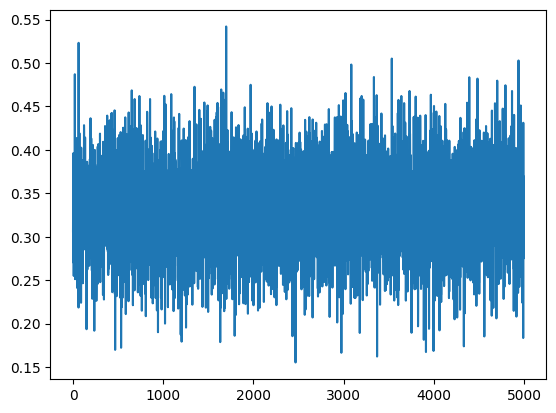

In [102]:
plt.plot(step_i, loss_i)


In [117]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_y_z_dim) @ W1 + b1) # Original dims: (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1290, grad_fn=<NllLossBackward0>)

In [118]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_y_z_dim) @ W1 + b1) # Original dims: (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2165, grad_fn=<NllLossBackward0>)

In [119]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_y_z_dim) @ W1 + b1) # Original dims: (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2048, grad_fn=<NllLossBackward0>)

In [ ]:
print(min(loss_i), max(loss_i))

In [ ]:
# TODO: Try to experiment with the alpha learning rate. Different values and methods
# In our example we should see that nothing really works here. It is underfitting no matter what tactic we use
# When something like this happens, it most likely means that the NN is too simple to handle the given task. We need to make it more complex. We have two options in NLP: 1. add hidden layers, or hidden layer neurons 2. add the neurons to the input layer

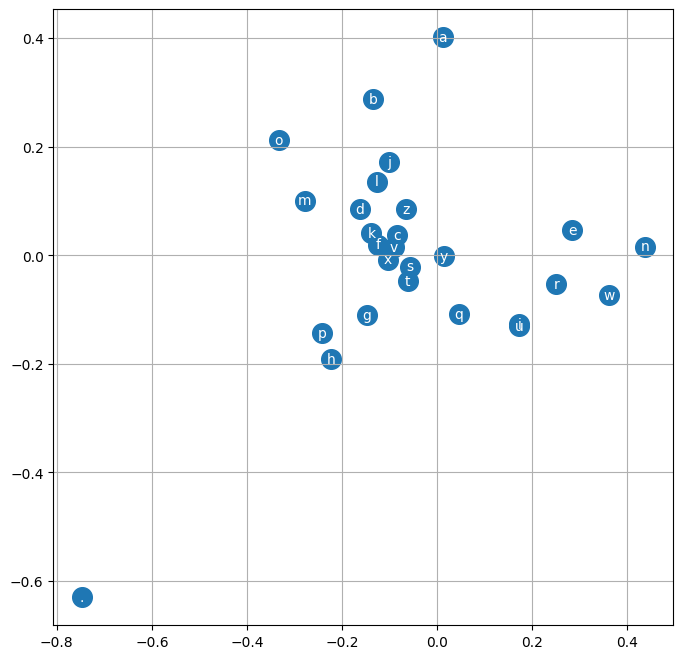

In [120]:
# Let's visualise something, so we have a better insight
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# we visualize this as two embedding locations
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [122]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eria.
kmyanniee.
medhayah.
rethrettal.
legra.
chedieli.
jelizona.
edeison.
anar.
kayzion.
kalin.
sheberghki.
jestin.
jowell.
panteula.
usten.
deriy.
julieh.
yuma.
myston.
